In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

# Sklearn functionality
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from yellowbrick.classifier import ConfusionMatrix

# Convenience functions.  This can be found on the course github
from functions import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data set
dataset = pd.read_csv("../data/csv/world_data.csv")

In [3]:
# Examine the date shape
dataset.shape

(194, 17)

In [4]:
# Inspect first few rows
dataset.head()

,country,happiness,income,lifeexp,sanitation,water,urbanpopulation,unemployment,literacy,inequality,murder,energy,childmortality,fertility,hiv,foodsupply,population
0,Afghanistan,3.982855,1750.0,57.9,39.2,63.0,11.0,NaN,39.0,NaN,NaN,NaN,73.2,4.80,5800.0,2090.0,33700000
1,Albania,4.606651,11000.0,77.6,97.7,91.4,NaN,6.090,96.8,29.0,2.30,808.0,14.0,1.71,NaN,3190.0,2920000
2,Argentina,6.697131,19100.0,76.5,94.8,99.6,43.1,0.856,97.9,41.4,4.65,2020.0,11.6,2.31,95000.0,3230.0,43400000
3,Armenia,4.348320,8180.0,75.4,91.6,98.9,36.7,7.110,99.6,32.4,1.12,1020.0,14.0,1.66,3600.0,2930.0,2920000
4,Australia,7.309061,43800.0,82.6,100.0,100.0,60.2,1.240,NaN,34.7,1.11,5480.0,3.8,1.86,22000.0,3280.0,23800000


In [5]:
# Check data types
dataset.dtypes

country             object
happiness          float64
income             float64
lifeexp            float64
sanitation         float64
water              float64
urbanpopulation    float64
unemployment       float64
literacy           float64
inequality         float64
murder             float64
energy             float64
childmortality     float64
fertility          float64
hiv                float64
foodsupply         float64
population           int64
dtype: object

In [6]:
# Check for nulls
dataset.isnull().mean().sort_values(ascending=False)

murder             0.520619
unemployment       0.422680
urbanpopulation    0.386598
happiness          0.278351
literacy           0.231959
hiv                0.231959
inequality         0.175258
foodsupply         0.134021
energy             0.128866
fertility          0.051546
lifeexp            0.036082
income             0.005155
childmortality     0.005155
country            0.000000
water              0.000000
sanitation         0.000000
population         0.000000
dtype: float64

In [7]:
# Discard very sparse features
dataset = dataset.drop(["murder","urbanpopulation","unemployment"], axis=1)

In [8]:
# Função para imputar a mediana nas colunas float
def impute_median_float(df):
    for col in df.select_dtypes(include='float'):
        median = df[col].median()
        df.fillna({col: median}, inplace=True)

impute_median_float(dataset)
dataset.head()

,country,happiness,income,lifeexp,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
0,Afghanistan,3.982855,1750.0,57.9,39.2,63.0,39.0,37.45,1250.0,73.2,4.80,5800.0,2090.0,33700000
1,Albania,4.606651,11000.0,77.6,97.7,91.4,96.8,29.00,808.0,14.0,1.71,24000.0,3190.0,2920000
2,Argentina,6.697131,19100.0,76.5,94.8,99.6,97.9,41.40,2020.0,11.6,2.31,95000.0,3230.0,43400000
3,Armenia,4.348320,8180.0,75.4,91.6,98.9,99.6,32.40,1020.0,14.0,1.66,3600.0,2930.0,2920000
4,Australia,7.309061,43800.0,82.6,100.0,100.0,90.0,34.70,5480.0,3.8,1.86,22000.0,3280.0,23800000


In [9]:
# Bin lifexp into L, M and H bands
dataset = appendEqualCountsClass(dataset, "lifeexp_band", "lifeexp", 3, ["L","M","H"])
# Check how many rows in each bin
dataset.lifeexp_band.value_counts()

lifeexp_band
L    65
H    65
M    64
Name: count, dtype: int64

In [10]:
# Split into input and target features
y = dataset["lifeexp_band"]
X = dataset[['happiness', 'income', 'sanitation', 'water', 'literacy', 'inequality', 'energy', 'childmortality', 'fertility',  'hiv', 'foodsupply', 'population']]


In [11]:
X.describe()
# Rescale the data
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

In [12]:
# Convert X back to a Pandas DataFrame, for convenience
X = pd.DataFrame(rescaledX, columns=X.columns)
X.describe()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.545949,0.140535,0.718449,0.830600,0.779496,0.469428,0.110477,0.216399,0.259521,0.030881,0.509600,0.027044
std,0.194619,0.159814,0.314995,0.217698,0.233259,0.156686,0.141861,0.231851,0.221615,0.099677,0.218657,0.101406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446821,0.022404,0.453562,0.726146,0.673025,0.375000,0.032539,0.044510,0.090909,0.001820,0.365079,0.001408
50%,0.536419,0.086926,0.869780,0.937423,0.866131,0.449353,0.066724,0.114985,0.180992,0.004275,0.500000,0.006017
75%,0.648486,0.196663,0.975248,0.991326,0.938086,0.551185,0.129928,0.348850,0.404545,0.014007,0.666667,0.019582
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Split into test and training sets
test_size = 0.33
seed = 1
X_train, X_test, Y_train, Y_test =  train_test_split(X, y, test_size = test_size, random_state = seed)

In [14]:
# Build a decision tree model
model = DecisionTreeClassifier()

# Definindo o grid de hiperparâmetros para serem testados
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)

# Treinando o GridSearchCV
grid_search.fit(X_train, Y_train)

# Imprimindo os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [15]:
# Acessando o melhor modelo encontrado
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)
print("DecisionTreeClassifier", accuracy_score(Y_test, predictions))

DecisionTreeClassifier 0.6923076923076923


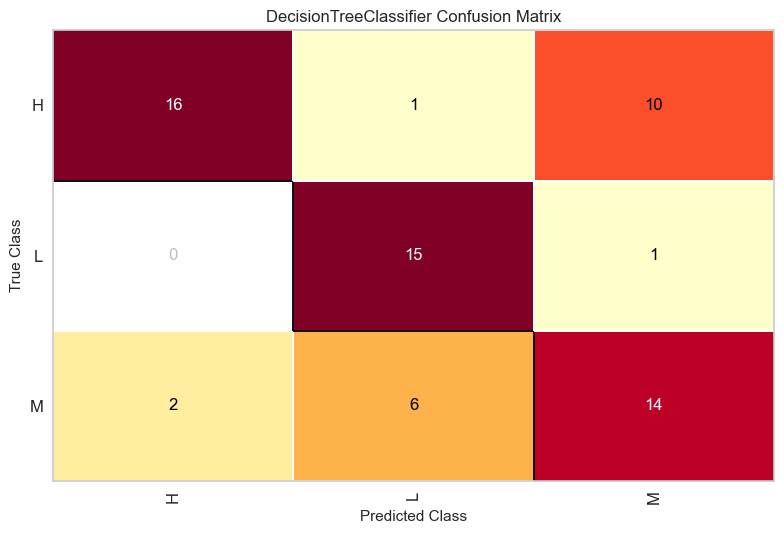

In [16]:
#matriz confusão
cm = ConfusionMatrix(
    best_model,
    percent=False
)
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show(outpath='cm.png');

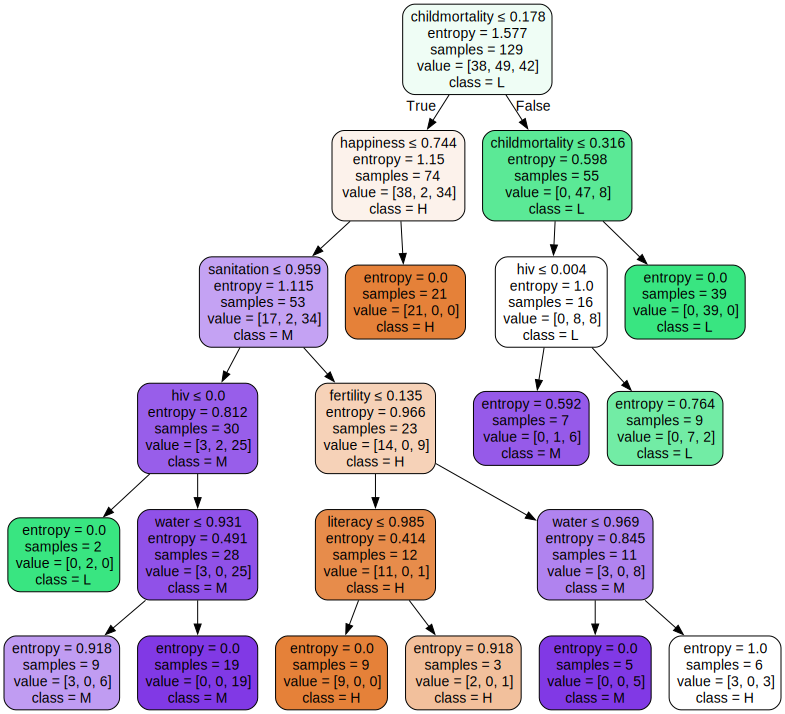

In [17]:
viewDecisionTree(best_model, X.columns)